## 영화리뷰 텍스트 감성분석하기

### 학습목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성분류 실습을 진행한다.

## 텍스트 데이터의 특징 (1) 텍스트를 숫자로 표현하는 방법

In [2]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [3]:
# 우리의 텍스트 데이터로부터 사전을 만들기 위해 모든 문장을 단어 단위로 쪼갠 후에 파이썬 딕셔너리(dict) 자료구조로 표현해 보겠습니다.

index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [4]:
# 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조로 만들기
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [5]:
# 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환하는 방식으로 사용
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [6]:
# 텍스트 데이터를 숫자로 바꿔 표현해 봅시다.
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [7]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [8]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [9]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


## 텍스트 데이터의 특징 (2) Embedding 레이어의 등장

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)


vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.

# Tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 
# 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.
# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.00124812  0.04944587  0.04787174  0.02194128]
  [-0.00503842  0.04706291 -0.00670772 -0.04544906]
  [ 0.0278203  -0.03118618 -0.02558228  0.03143957]
  [ 0.04928267 -0.01618923 -0.01138036  0.02070601]
  [ 0.01469148 -0.01841965  0.03804687 -0.02832984]]

 [[ 0.00124812  0.04944587  0.04787174  0.02194128]
  [-0.00503842  0.04706291 -0.00670772 -0.04544906]
  [-0.01974069  0.029032   -0.0358946  -0.02455076]
  [ 0.03990041 -0.04922242 -0.04353397  0.03506634]
  [ 0.01469148 -0.01841965  0.03804687 -0.02832984]]

 [[ 0.00124812  0.04944587  0.04787174  0.02194128]
  [ 0.03357366 -0.01559075 -0.04126525 -0.04898298]
  [-0.00503842  0.04706291 -0.00670772 -0.04544906]
  [ 0.0278203  -0.03118618 -0.02558228  0.03143957]
  [-0.03214216  0.01279092  0.04503608  0.0328506 ]]], shape=(3, 5, 4), dtype=float32)


## 시퀀스 데이터를 다루는 RNN

In [12]:
# RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제코드
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


## 꼭 RNN이어야 할까?

In [13]:
# 텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)을 사용할 수도 있습니다.
# 우리는 이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있습니다. 이미지는 시퀀스 데이터가 아닙니다. 이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용됩니다.
# 그러므로 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다.
# 그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습속도도 훨씬 빠르게 진행된다는 장점이 있습니다.

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
# 아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있습니다. 
# 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 
# 의외로 성능이 잘 나올 수도 있습니다.

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화리뷰 감성분석 (1) IMDB 데이터셋 분석

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [16]:
# imdb.load_data() 호출시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 
# 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [17]:
# 텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드받았음을 확인할 수 있습니다.
# 이미 텍스트가 encode되었으므로 IMDB 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공합니다.

word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [18]:
# MDB 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 아래와 같이 보정되어야 합니다. 
# 아래 내용은 Tensorflow 튜토리얼의 가이드를 반영하여 작성하였습니다.
# word_to_index는 IMDB 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다.

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [19]:
# 다운받은 데이터셋이 확인되었습니다. 마지막으로, encode된 텍스트가 정상적으로 decode되는지 확인해 보겠습니다.

print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [20]:
# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
# 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다. 
# 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다.

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [21]:
# 위의 경우에는 maxlen=580이 됩니다.
# 또 한가지 유의해야 하는 것은 padding 방식을 문장 뒷쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 
# RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
# 두 가지 방식을 한번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보시기 바랍니다.

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## IMDB 영화리뷰 감성분석 (2) 딥러닝 모델 설계와 훈련

In [22]:
# RNN 모델을 직접 설계해 보자

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 우리가 사용할 수 있는 모델에는 RNN만 있는 것이 아닙니다. 이전 스텝에서 구현해 본 다양한 모델들이 전부 사용 가능합니다.

# model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 
# 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [24]:
# model 학습을 시작해 봅시다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.6910 - accuracy: 0.5778 - val_loss: 0.6877 - val_accuracy: 0.5936
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.6813 - accuracy: 0.6567 - val_loss: 0.6743 - val_accuracy: 0.6457
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6579 - accuracy: 0.7457 - val_loss: 0.6456 - val_accuracy: 0.7517
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.6204 - accuracy: 0.7853 - val_loss: 0.6064 - val_accuracy: 0.7936
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5720 - accuracy: 0.8308 - val_loss: 0.5605 - val_accuracy: 0.8125
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5180 - accuracy: 0.8475 - val_loss: 0.5130 - val_accuracy: 0.8233
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4631 - accuracy: 0.8631 - val_loss: 0.4678 - val_accuracy: 0.8320
Epoch 8/20
30

In [25]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3580 - accuracy: 0.8466
[0.35797441005706787, 0.8465999960899353]


In [26]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 
# 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


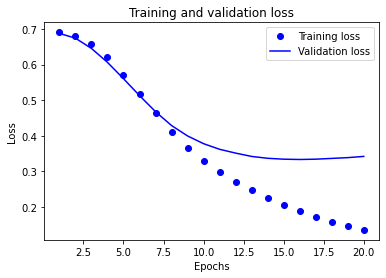

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

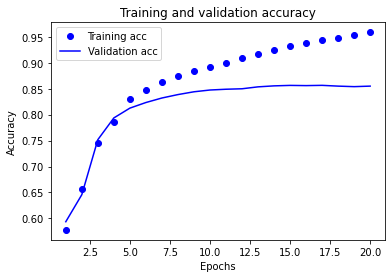

In [29]:
# Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. 
# validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.
# 마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있습니다.

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [30]:
# RNN 모델을 직접 설계해 보겠습니다. 이전 스텝의 실습 내용을 참고해 주세요.

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [31]:
# (참고)우리가 사용할 수 있는 모델에는 RNN만 있는 것이 아닙니다. 이전 스텝에서 구현해 본 다양한 모델들이 전부 사용 가능합니다.
# model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 
# 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [32]:
# model 학습을 시작해 봅시다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.6907 - accuracy: 0.5001 - val_loss: 0.6862 - val_accuracy: 0.5556
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6801 - accuracy: 0.6327 - val_loss: 0.6720 - val_accuracy: 0.7220
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.6594 - accuracy: 0.7546 - val_loss: 0.6479 - val_accuracy: 0.7804
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6274 - accuracy: 0.7985 - val_loss: 0.6127 - val_accuracy: 0.7975
Epoch 5/20
30/30 [==============================] - 0s 17ms/step - loss: 0.5817 - accuracy: 0.8275 - val_loss: 0.5670 - val_accuracy: 0.8151
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5255 - accuracy: 0.8477 - val_loss: 0.5149 - val_accuracy: 0.8257
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4662 - accuracy: 0.8595 - val_loss: 0.4664 - val_accuracy: 0.8320
Epoch 8/20
30

In [33]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3559 - accuracy: 0.8461
[0.3558863699436188, 0.8461199998855591]


In [34]:
# model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
# 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 
# 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


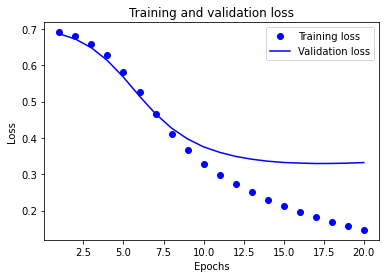

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

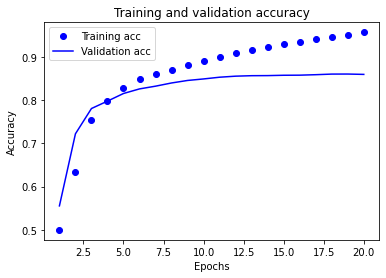

In [37]:
# Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. 
# validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.
# 마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있습니다.


plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 프로젝트 제출

### 프로젝트 루브릭 : 아래의 기준을 바탕으로 프로젝트를 평가합니다.

### 평가문항

1. 모델과 레이어의 선택이 용도에 맞고 합리적인가?
2. normalization, regularization 등이 필요한 만큼 잘 활용되었는가?
3. 파라미터 사이즈는 적절히 선택되었는가?